In [1]:
%load_ext autoreload
%autoreload 2

#Science and Data
import pandas as pd
import numpy as np
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

# Infrastructure
from pathlib import Path
import sys
import os

#Plotting Tools
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import theano

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# Pandas
pd.set_option('display.max_rows', 100)

# Matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'font.size': 18})

# Epidemiological Example

## Deterministic Formulation

The function describing the epidemiological formulation is given by

In [ ]:
$$
\begin{array}{rcl}
\dot{S}&=&-\beta SI\\
\dot{I}
\end{array}
$$

Integration successful.


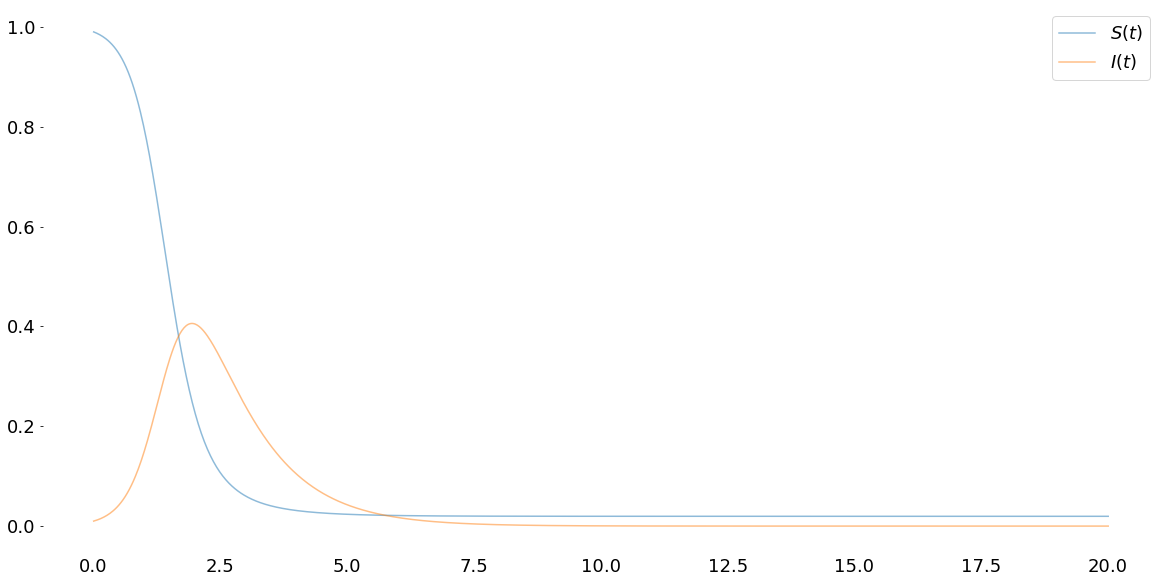

In [163]:
def f(y, t, p):
    
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    
    return np.array([ds, di])

np.linspace(0, 15,  1000)
y0=[0.99, 0.01]

beta, lam = 4,1.0
# Create true curves
y, infodict = odeint(f, y0, t, args=((beta,lam),), rtol=1e-8, full_output=True)
print(infodict["message"])
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])


# plt.plot(t[1::],yobs, marker='o', linestyle='none')
plt.plot(t, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(t, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()


src: https://docs.pymc.io/notebooks/ODE_API_introduction.html

In [3]:
def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    return [ds, di]

sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

times = np.arange(0,5,0.25)

beta,gamma = 4,1.0

y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta,gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lam = pm.Lognormal('lambda',pm.math.log(2),2)
    beta = pm.Deterministic('beta', lam*R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(tune=10, cores=5, target_accept=0.9, return_inferencedata=False)
    try:
        posterior_predictive = pm.sample_posterior_predictive(trace)
        
    except Exception:
        posterior_predictive = pm.sample_posterior_predictive(trace.posterior)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [lambda, R0, sigma]


Sampling 5 chains for 10 tune and 1_000 draw iterations (50 + 5_000 draws total) took 909 seconds.
There were 434 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1981239820300287, but should be close to 0.9. Try to increase the number of tuning steps.
There were 367 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29470251394299796, but should be close to 0.9. Try to increase the number of tuning steps.
There were 311 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.36386056649706155, but should be close to 0.9. Try to increase the number of tuning steps.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49797698954314024, but should be close to

/opt/conda/lib/python3.7/site-packages/arviz/utils.py:653: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


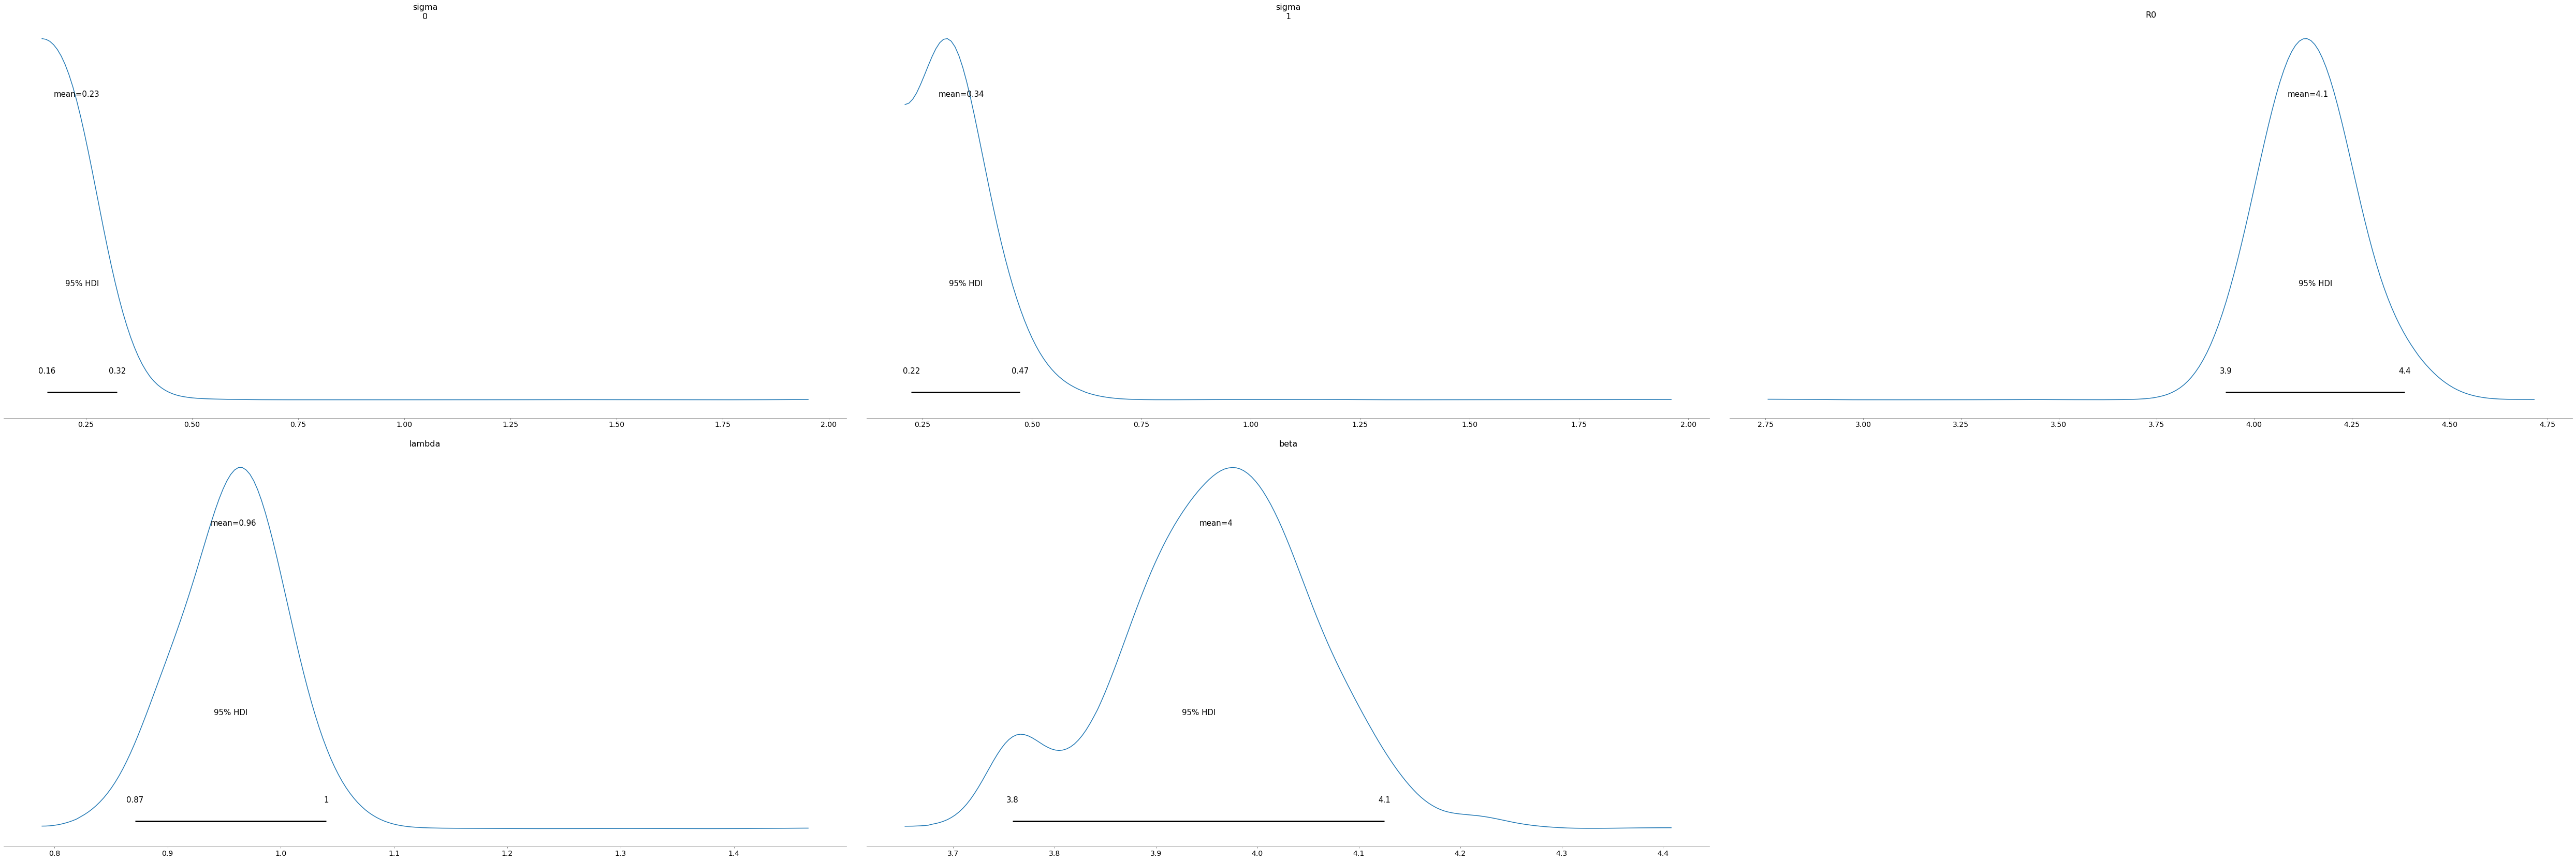

In [6]:
az.plot_posterior(data,round_to=2, credible_interval=0.95);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc55023a278>,
      dtype=object)

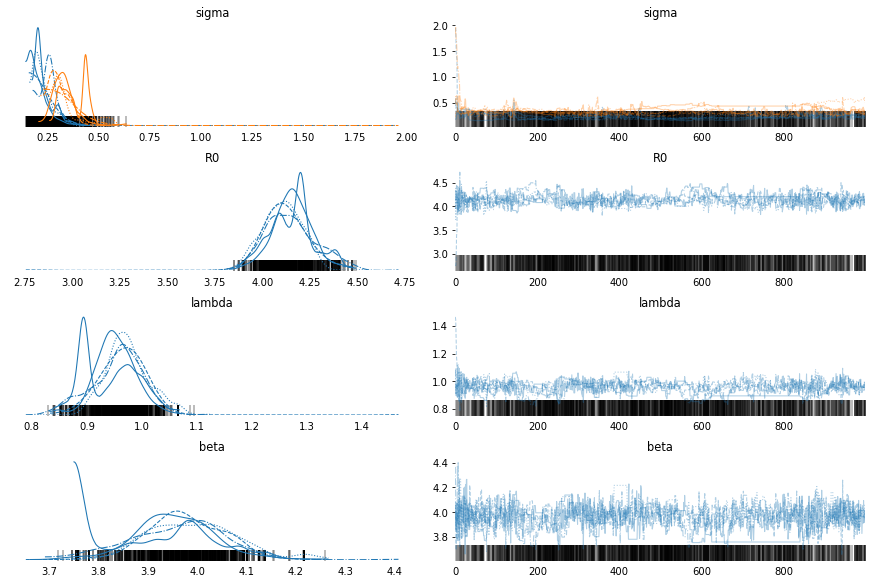

In [16]:
pm.traceplot(trace)

In [39]:
trace["lambda"]

array([0.92602791, 0.91078738, 0.95435409, ..., 0.96401172, 0.97724967,
       0.96013583])

In [36]:
posterior_predictive["Y"].shape

(5000, 19, 2)

In [32]:
np.asarray(posterior_predictive["Y"]).shape

(5000, 19, 2)

beta=3.865806067422198, lambda=0.9097490026243414
Integration successful.
beta=3.995386519050759, lambda=0.9762270783460385
Integration successful.


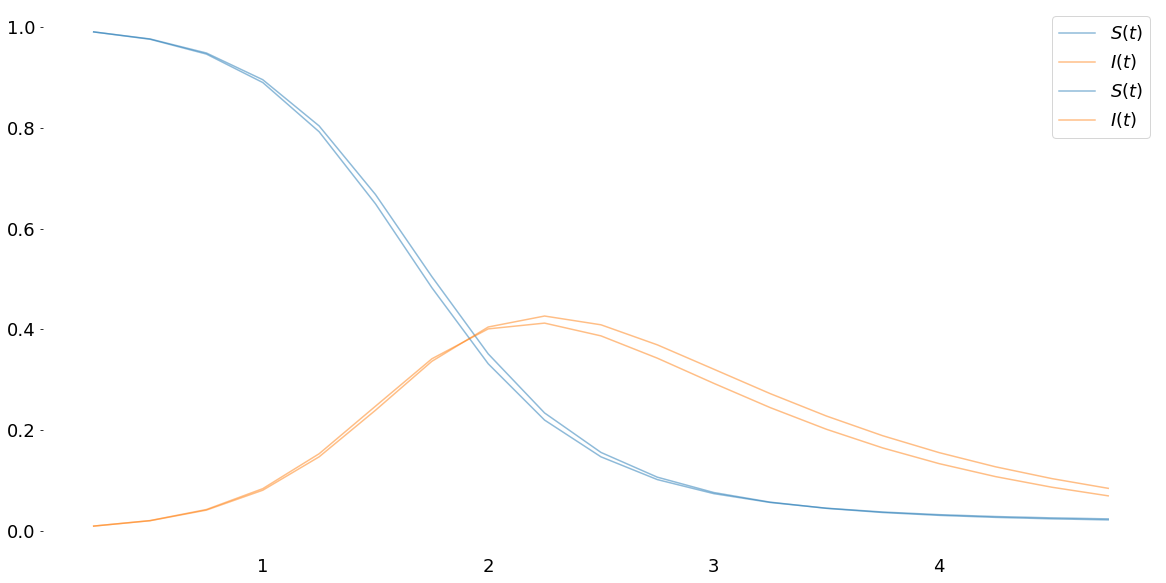

In [49]:
def f(y, t, p):
    
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    
    return np.array([ds, di])

t=np.arange(0.25, 5, 0.25)
for i in range(np.asarray(posterior_predictive["Y"]).shape[2]):
    ndx = np.random.randint(0, len(trace))
    beta, lam = trace[ndx]['beta'], trace[ndx]['lambda']
    print(f"beta={beta}, lambda={lam}")
    
#     def f(y, t, p):
    
#     ds = -p[0]*y[0]*y[1]
#     di = p[0]*y[0]*y[1] - p[1]*y[1]
    
#     return np.array([ds, di])

#     np.linspace(0, 15,  1000)
#     y0=[0.99, 0.01]

#     beta,gamma = 4,1.0
#     # Create true curves
    y, infodict = odeint(f, y0=[0.99, 0.01], t=t, args=((beta,lam),), rtol=1e-8, full_output=True)
    plt.plot(t, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
    plt.plot(t, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
    plt.legend()
    print(infodict["message"])

# Competitive Model

## Simple Lotka-Volterra

src: 
* https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html
* https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations

The model was proposed independently by Alfred J. Lotka in 1925 and Vito Volterra in 1926, and can be described by

$$
\begin{array}{rcl}
\dot{u}& =& au(t) - bu(t)v(t)\\
\dot{v}& =& -cv(t) + dbu(t)v(t)
\end{array}
$$

with the following notations:

* u: number of preys (for example, rabbits)
* v: number of predators (for example, foxes)
* a, b, c, d are constant parameters defining the behavior of the population:
    * a is the natural growing rate of rabbits, when there's no fox
    * b is the natural dying rate of rabbits, due to predation
    * c is the natural dying rate of fox, when there's no rabbit
    * d is the factor describing how many caught rabbits let create a new fox



In [109]:
import pylab as p
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75
def f(x, t=0):
    """ Return the growth rate of fox and rabbit populations. """
    
    dx = a*x[0] -   b*x[0]*x[1]
    dy = -c*x[1] + d*b*x[0]*x[1]
    
    return np.array([dx, dy])

In [110]:
t = np.linspace(0, 15,  1000)              # time
x0 = np.array([10, 10])                     # initials conditions: 10 rabbits and 5 foxes
x, infodict = odeint(f, x0, t, full_output=True)
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

Text(0.5, 1.0, 'Evolution of fox and rabbit populations')

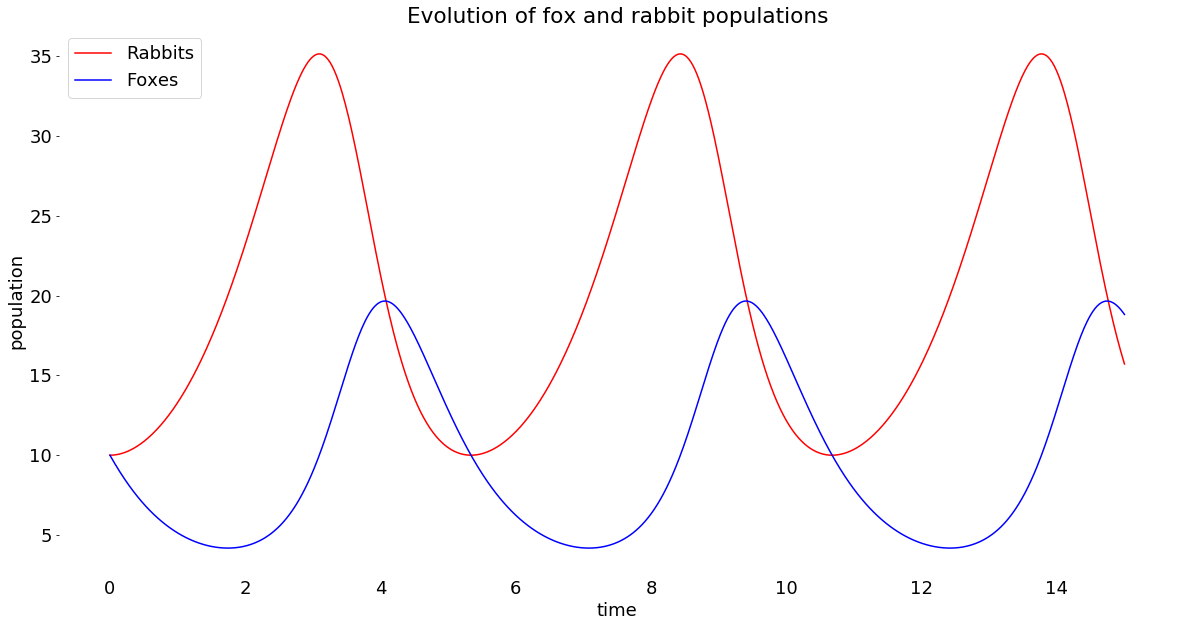

In [111]:
rabbits, foxes = x.T
f1 = p.figure()
p.plot(t, rabbits, 'r-', label='Rabbits')
p.plot(t, foxes  , 'b-', label='Foxes')
# p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations')
# f1.savefig('rabbits_and_foxes_1.png')


## Competitive Lotka–Volterra equations

src:https://en.wikipedia.org/wiki/Competitive_Lotka%E2%80%93Volterra_equations

In [102]:
r1, r2, alpha12, alpha21 = 1, 0.72, 1.09, 0
K1, K2 = 1, 1
def f(x, t=0):
    
    dx = r1*x[0]*(1.0 - (x[0] + alpha12*x[1])/K1)
    dy = r2*x[1]*(1.0 - (x[1] + alpha21*x[0])/K2)
    
    return [dx, dy]

In [103]:
t = np.linspace(0, 15,  1000)
x0=np.array([10, 10])

# Create true curves
x, infodict = odeint(f, x0, t, full_output=True)

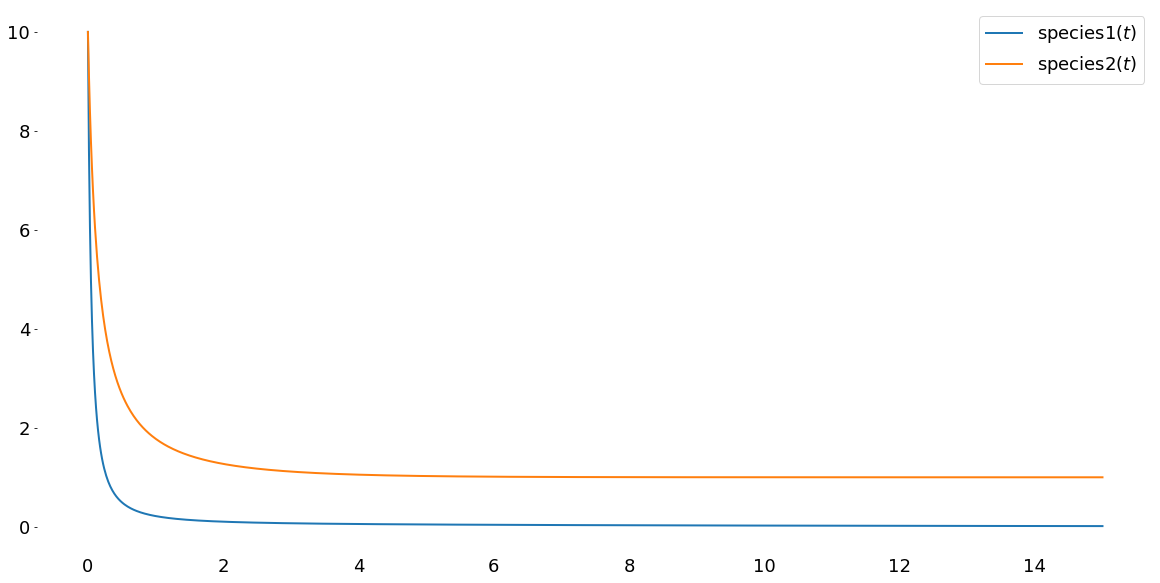

In [108]:
species1, species2 = x.T


plt.plot(t, species1, label=f'species1$(t)$', linewidth=2)
plt.plot(t, species2, label=f'species2$(t)$', linewidth=2)
plt.legend()
plt.show()


## Competitive Lokta-Volterra with a Single Prey

Reference

* Qiumei Zhang and Daqing Jiang, "The coexistence of a stochastic Lotka-Volterra model with two predators competing for one prey", Applied Mathematics and Computation, pp. 288--300, 2015, `DOI: 10.1016/j.amc.2015.07.054`

* Llibre, J.; Xiao, D. -- Global Dynamics of a Lotka-Volterra Model with Two Predators Competing for One Prey. `DOI: 10.1137/130923907`

* Dynamic Models of Competition Systems Involving Generalized Functional Response. `DOI: 10.1007/s12591-017-0398-y`

* Kishimoto, K. (1982). The diffusive Lotka-Volterra system with three species can have a stable non-constant equilibrium solution. Journal of Mathematical Biology, 16(1), 103–112. doi:10.1007/bf00275163 

In [17]:
b1 = 1.5
b2 = 0.9
b3 = 1.2
a11 = 0.3
a12 = 0.2
a13 = 0.3
b21 = 0.3
b31 = 0.4

In [18]:
def f(x, t=0):
    
    ds = x[0]*(b1 - a11*x[0] - a12*x[1] - a13*x[2])
    dx = x[1]*(-b2 + b21*x[0])
    dy = x[2]*(-b3 + b31*x[0])
    
    return [ds, dx, dy]

In [29]:
t = np.linspace(0, 20,  1000)
x0=np.array([1, 2, 5])

# Create true curves
x, infodict = odeint(f, x0, t, full_output=True)

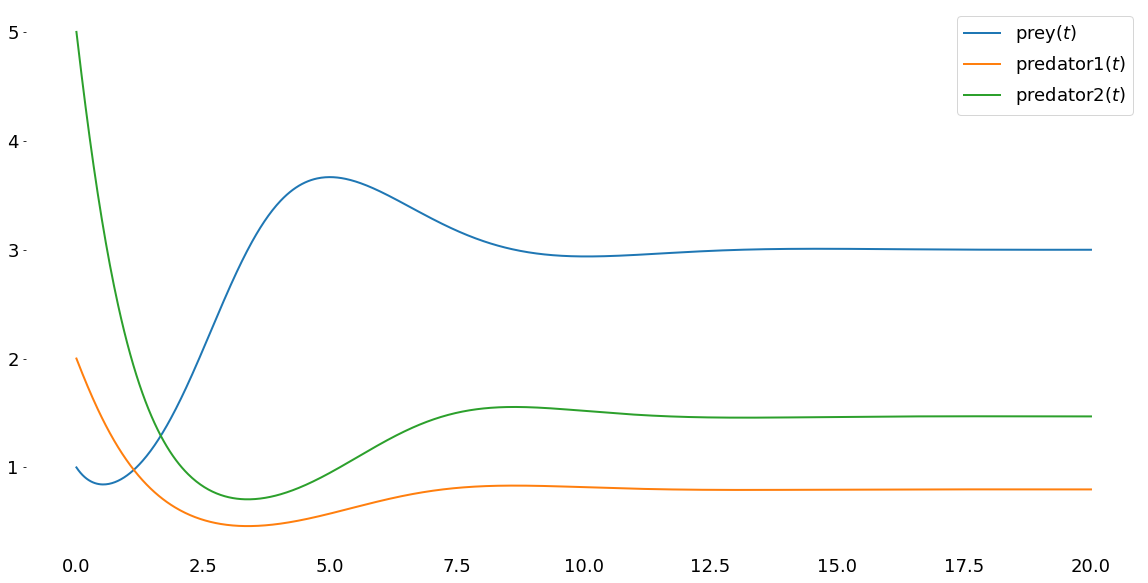

In [30]:
prey, predator1, predator2 = x.T

plt.plot(t, prey, label=f'prey$(t)$', linewidth=2)
plt.plot(t, predator1, label=f'predator1$(t)$', linewidth=2)
plt.plot(t, predator2, label=f'predator2$(t)$', linewidth=2)
plt.legend()
plt.show()


# Lotka-Volterra and Epidemiology

In [157]:
import pylab as p
# Definition of parameters
a = 1.
b = 0.1
c = 1.5
d = 0.75
p0 = 4
p1 = 1.0
def f(x, t=0):
    """ Return the growth rate of fox and rabbit populations. """
    
    dx = a*x[0] -   b*x[0]*x[1]
    dy = -c*x[1] + d*b*x[0]*x[1]
    di = p0*x[0]*x[2] - p1*x[2]
    
    return np.array([dx, dy, di])

In [158]:
t = np.linspace(0, 20,  1000)
x0=np.array([10, 10, 1])

# Create true curves
x, infodict = odeint(f, x0, t, full_output=True)

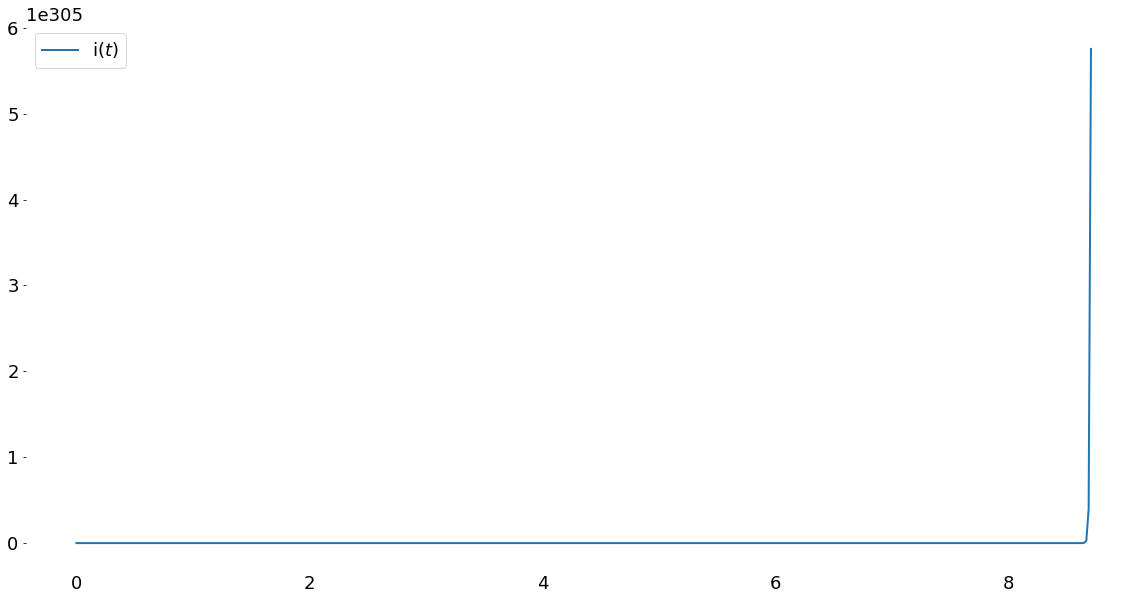

In [161]:
prey, predator, i = x.T

# plt.plot(t, prey, label=f'prey$(t)$', linewidth=2)
# plt.plot(t, predator, label=f'predator$(t)$', linewidth=2)
plt.plot(t, i, label=f'i$(t)$', linewidth=2)
plt.legend()
plt.show()


## The Competitive Case

In [122]:
b1 = 1.5
b2 = 0.9
b3 = 1.2
a11 = 0.3
a12 = 0.2
a13 = 0.3
b21 = 0.3
b31 = 0.4
p0 = 4
p1 = 1.0

In [127]:
def f(x, t=0):
    
    
    ds = x[0]*(-b1*x[3] - a11*x[0] - a12*x[1] - a13*x[2])
    dx = x[1]*(-b2 + b21*x[0])
    dy = x[2]*(-b3 + b31*x[0])
    di = p0*x[0]*x[3] - p1*x[3]
    
    return [ds, dx, dy, di]

In [132]:
t = np.linspace(0, 20,  1000)
x0 = np.array([10, 10, 10, 0.01])

# Create true curves
x, infodict = odeint(f, x0, t, full_output=True)

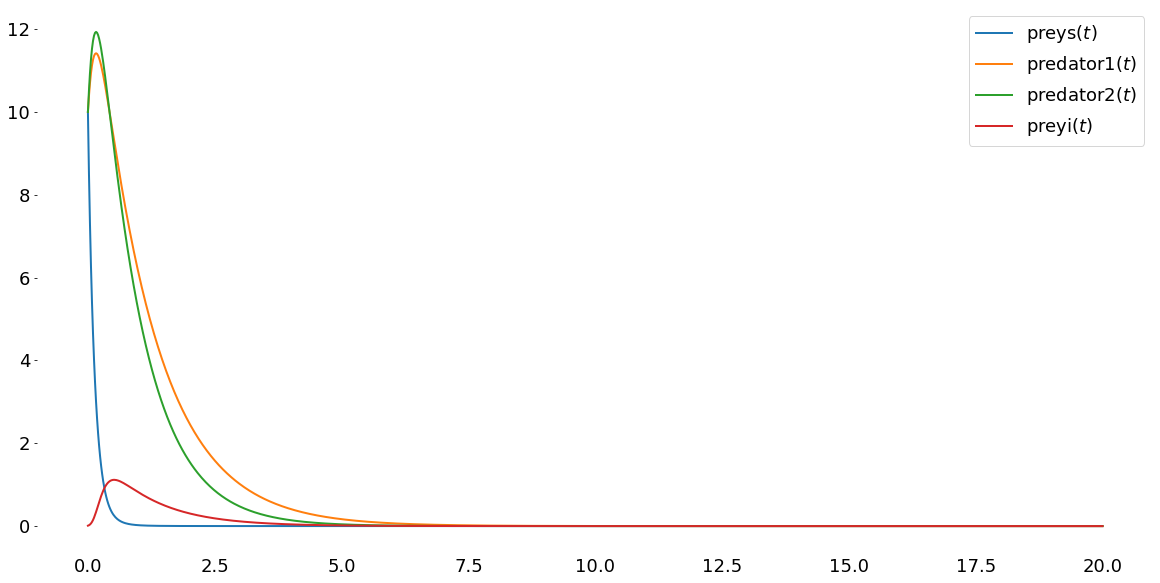

In [133]:
preys, predator1, predator2, preyi = x.T

plt.plot(t, preys, label=f'preys$(t)$', linewidth=2)
plt.plot(t, predator1, label=f'predator1$(t)$', linewidth=2)
plt.plot(t, predator2, label=f'predator2$(t)$', linewidth=2)
plt.plot(t, preyi, label=f'preyi$(t)$', linewidth=2)
plt.legend()
plt.show()
